# Setup

In [1]:
import numpy as np
import pylab as plt

from sklearn.datasets import make_moons, make_circles, fetch_openml

In [2]:
# Vanilla PCA for comparison
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        X = np.array(X)
        N, D = X.shape
        self.mu_ = np.mean(X, axis=0)
        S = ((X-self.mu_).T @ (X-self.mu_)) / N
        self.lmbdas_, self.U_ = np.linalg.eigh(S)
        sort_idx = np.argsort(-self.lmbdas_)
        self.lmbdas_ = self.lmbdas_[sort_idx]
        self.U_ = self.U_[:, sort_idx]
        self._determine_M()
        return self

    def transform(self, X):
        B = self.U_[:, :self.M_]
        X = np.array(X)
        Z = (X-self.mu_) @ B
        return Z

    def inverse_transform(self, Z):
        B = self.U_[:, :self.M_]
        Z = np.array(Z)
        X = Z @ B.T
        X += self.mu_
        return X

    def _determine_M(self):
        if self.n_components >= 1:
            self.M_ = self.n_components
        elif 0 < self.n_components < 1:
            cum_lmbdas = np.cumsum(self.lmbdas_ / np.sum(self.lmbdas_))
            self.M_ = np.argmax(cum_lmbdas >= self.n_components) + 1
        else:
            raise ValueError('Invalid `n_components` parameter.')

# **Principal Component Analysis - Extensions**
In this notebook, we will implement two extensions to the *principal component analysis* (PCA) algorithm.
First, we will implement the high-dimensional data version, which takes care of the case where the number of samples $N$ is smaller than the number of features $D$. Subsquently, we will implement the kernel version which allows to obtain projected data of a PCA in an unknown feature space.

Mathematically, we denote an obtained data set consisting of $N$ samples as a matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$, where the $n$-th row of this matrix represents the $n$-th samples being a $D$-dimensional feature vector: $\mathbf{x}_n = (x_{n1}, \dots, x_{nD})^\mathrm{T}$.

## **High-dimensional PCA**

In [4]:
X_img_all, y_img_all = fetch_openml('mnist_784', version=1, return_X_y=True)
# convert from pandas to numpy if necessary

idx = np.random.choice(range(len(X_img_all)), replace=False, size=20)
X_img = X_img_all.values[idx]
y_img = y_img_all.values[idx]

> A corresponding class for high-dimensional PCA is to be implemented below.

In [31]:
class HighDimPCA(PCA):
    """ This class implements the principal component analysis for N < D,
        where N is the number of samples and D is the number of features.
    """
    def fit(self, X):
        X = np.array(X)
        N, D = X.shape
        self.mu_ = np.mean(X, axis=0)
        #S = ((X-self.mu_).T @ (X-self.mu_)) / N
        self.lmbdas_, self.V_ = np.linalg.eigh(1/N * X.T @ X)
        sort_idx = np.argsort(-self.lmbdas_)
        self.lmbdas_ = self.lmbdas_[sort_idx]
        self.V_ = self.V_[:, sort_idx]
        self.U_ = np.array([1/np.sqrt(N * self.lmbdas_[i]) * X @ self.V_[i] for i in range(N)])
        self._determine_M()
        return self

> Compare its runtime against the vanilla PCA implementation (e.g., using `%timeit`)

In [6]:
# Example for timeit
%timeit np.dot(5, 5)

646 ns ± 3.04 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [32]:
num_comp = 25
%timeit normal_pca = PCA(n_components=num_comp).fit(X_img)
%timeit highdim_pca = HighDimPCA(n_components=num_comp).fit(X_img)

86.2 ms ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
74.5 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## **Kernel PCA**

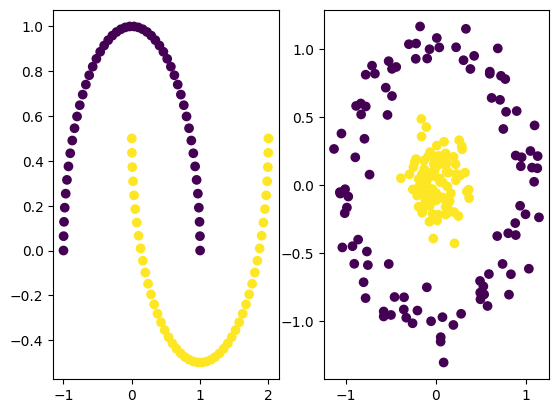

In [33]:
X_moons, y_moons = make_moons(n_samples=100, random_state=0)
X_circles, y_circles = make_circles(n_samples=200, factor=.2, noise=.1)

plt.subplot(121)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)

plt.subplot(122)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles)
plt.show()

> Implement a standard PCA algorithm using sklearn. Reduce the number of components and try to explain why standard PCA is not working here.

(100, 2)


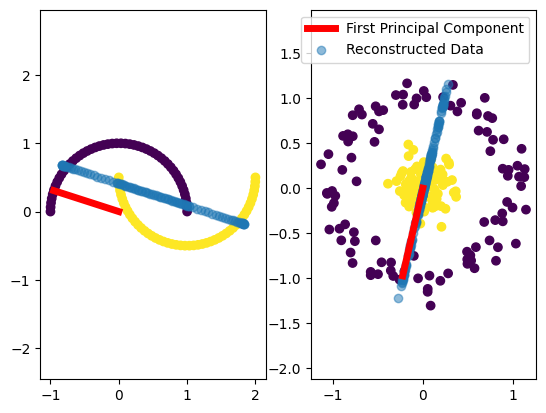

In [46]:
from sklearn.decomposition import PCA as skPCA
n = 1
print(X_moons.shape)
std_pca_moons = skPCA(n_components=n).fit(X_moons)
X_moons_pca = std_pca_moons.transform(X_moons)
X_moons_rec = std_pca_moons.inverse_transform(X_moons_pca)

std_pca_circles = skPCA(n_components=n).fit(X_circles)
X_circles_pca = std_pca_circles.transform(X_circles)
X_circles_rec = std_pca_circles.inverse_transform(X_circles_pca)

plt.subplot(121)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
# Plot the first principal component.
# start at 0,0 -> bc data was standardized, vector not on projection space
plt.plot([0, std_pca_moons.components_[0, 0]], [0, std_pca_moons.components_[0, 1]], color='red', lw=5, label='First Principal Component')
#plot the second principal component
#plt.plot([0, std_pca_moons.components_[1, 0]], [0, std_pca_moons.components_[1, 1]], color='green', lw=5, label='Second Principal Component')
plt.scatter(X_moons_rec[:, 0], X_moons_rec[:, 1], label='Reconstructed Data', alpha=0.5)
plt.axis('equal')

plt.subplot(122)
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles)
# Plot the first principal component.
plt.plot([0, std_pca_circles.components_[0, 0]], [0, std_pca_circles.components_[0, 1]], color='red', lw=5, label='First Principal Component')
#plot the second principal component
#plt.plot([0, std_pca_circles.components_[1, 0]], [0, std_pca_circles.components_[1, 1]], color='green', lw=5, label='Second Principal Component')
plt.scatter(X_circles_rec[:, 0], X_circles_rec[:, 1], label='Reconstructed Data', alpha=0.5)
plt.axis('equal')
plt.legend()
plt.show()

nonlinear relationship not decorrelated by linear pca

> Implement the Gaussian kernel given by: $$k_\sigma(\mathbf{x},\mathbf{x}^{\prime})=\exp(-\left\Vert \mathbf{x}-\mathbf{x}^{\prime}\right\Vert ^{2}/\sigma) $$

In [47]:
class GaussianKernel:
    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, x, y):
        return np.exp(-np.linalg.norm(x-y)**2 / (self.sigma))

> A corresponding class for the KernelPCA is to be implemented below.

In [80]:
class KernelPCA:
    """This class implements the kernel version of the principal component analysis.

    Args:
        n_comonents (int): Number of components to consider.

    """
    def __init__(self, n_components, kernel_func):
        self.n_components = n_components
        self.kernel_func = kernel_func

    def fit(self, X):
        """Determine required parameters of the Kernel PCA.

        Args:
            X (array-like): Input samples.

        Returns:
            The fitted PCA object.
        """
        self.X_ = X
        centered_gram = self.center_gram_matrix(self.get_gram_matrix(X))
        self.lmbdas_, self.A_ = np.linalg.eigh(centered_gram)
        sort_idx = np.argsort(-self.lmbdas_)
        self.lmbdas_ = self.lmbdas_[sort_idx]
        self.A_ = self.A_[:, sort_idx]  # eigenvectors of centered gram/ Kernel matrix


    def get_gram_matrix(self, X1, X2=None):
        """ Computes the gram marix.

        Args:
            X (ndarray): Samples in the input space.

        Returns
            The gram matrix for all samples.
        """
        return np.array([[self.kernel_func(x1, x2) for x1 in X1] for x2 in (X2 if X2 is not None else X1)])


    def center_gram_matrix(self, K):
        """ Computes the gram matrix with centered features.

        Args:
            K (ndarray): Gram matrix computed by a kernel.

        Returns
            Transformed gram matrix with mean zero in the projection space.
        """
        N = K.shape[0]
        one_n = np.ones((N, K.shape[1])) / N
        K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
        return K_centered

    def transform(self, X):
        """ Transforms samples from the D-dimensional input space into
            the M-dimensional projection space.

        Args:
            X (ndarray): Samples in the input space.

        Returns
            Transformed samples in the projection space.
        """
        # why does not centering matrix work?
        return np.array([self.A_[:, i] @ self.get_gram_matrix(self.X_, X).T for i in range(self.n_components)]).T

> Apply the Kernel PCA to the two-dimensional toy data sets and plot the features space projected on some principal components.

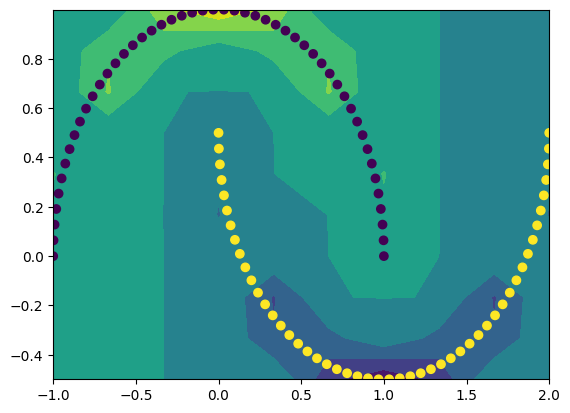

In [82]:
kernel_pca = KernelPCA(n_components=1, kernel_func=GaussianKernel(sigma=0.01))
kernel_pca.fit(X_moons)
X_moons_kpca = kernel_pca.transform(X_moons)

x,y = np.meshgrid(np.linspace(min(X_moons[:,0]), max(X_moons[:,0]), 10), np.linspace(min(X_moons[:,1]), max(X_moons[:,1]), 10))
data_grid = np.array([x,y]).reshape(2, -1).T
B = kernel_pca.transform(data_grid)

fig = plt.figure()
ax1 = plt.contourf(x, y, B.reshape(10,10))
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)


In [ ]:
####################
# Your Code Here   #
####################